In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import ipywidgets as widgets

import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

import time

import os

## Import data as pandas Dataframe

In [2]:
#change this to your folder containing the csv files
path = 'Store Item Demand Forecasting/data/'

In [3]:
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')
sub = pd.read_csv(f'{path}sample_submission.csv')

In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [6]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [7]:
test.date = pd.to_datetime(test.date)
train.date = pd.to_datetime(train.date)

In [8]:
train.shape

(913000, 4)

## Sales distribution across the train data

In [9]:
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df['sales'], [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

## Visualizing the distribution

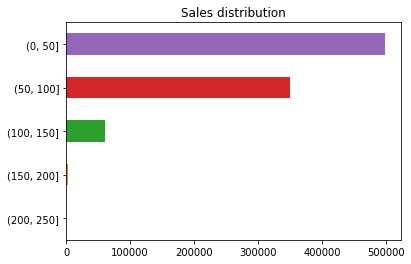

In [10]:
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
#sns.countplot(sales_count)

## Adding date features

In [11]:
for df in train, test:
    df['dayofmonth'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year
    df['weekofyear'] = df.date.dt.weekofyear
    df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
    df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
    df.head()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 12 columns):
date              913000 non-null datetime64[ns]
store             913000 non-null int64
item              913000 non-null int64
sales             913000 non-null int64
dayofmonth        913000 non-null int64
dayofyear         913000 non-null int64
dayofweek         913000 non-null int64
month             913000 non-null int64
year              913000 non-null int64
weekofyear        913000 non-null int64
is_month_start    913000 non-null int32
is_month_end      913000 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(9)
memory usage: 76.6 MB


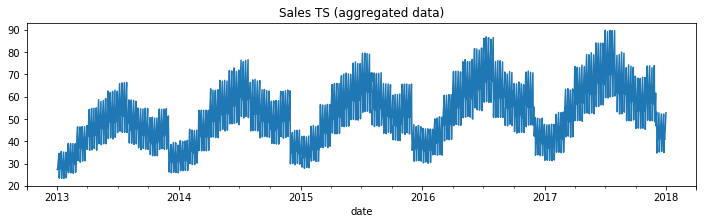

In [13]:
train.groupby('date').mean()['sales'].plot(figsize=(12,3), title='Sales TS (aggregated data)')

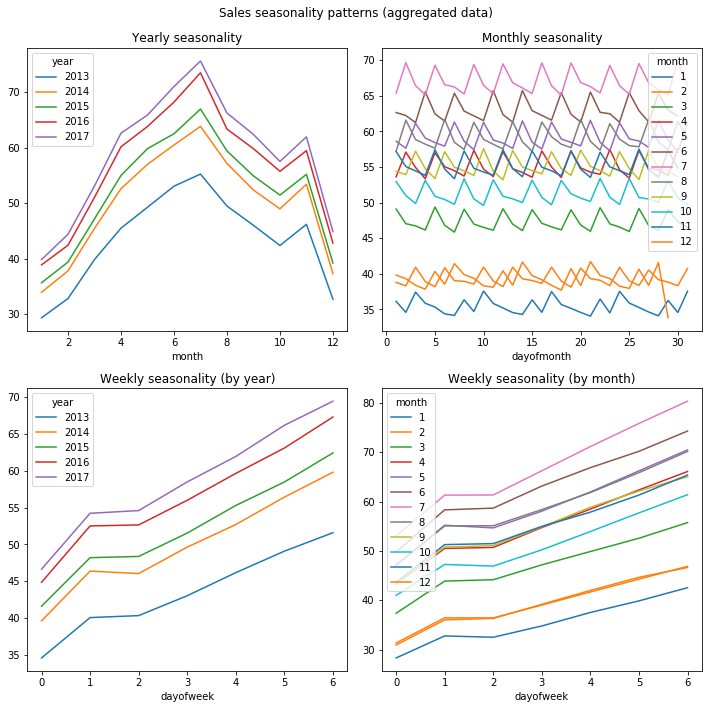

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(train, values='sales', columns='year', index='month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(train, values='sales', columns='month', index='dayofmonth').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(train, values='sales', columns='year', index='dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(train, values='sales', columns='month', index='dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

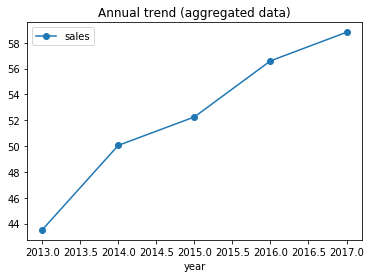

In [15]:
_ = pd.pivot_table(train, values='sales', index='year').plot(style='-o', title="Annual trend (aggregated data)")

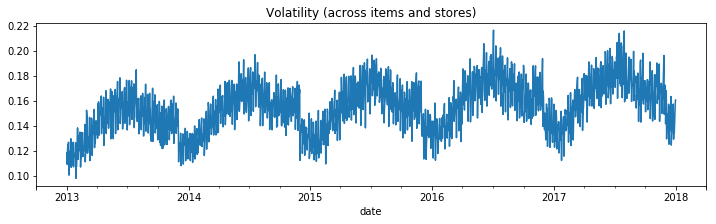

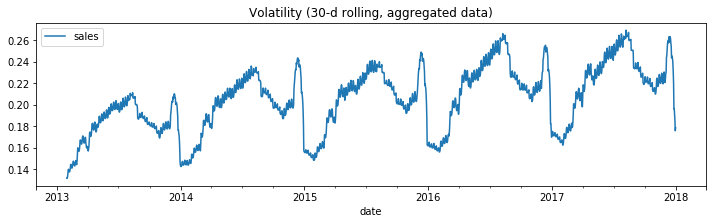

In [16]:
train_norm = train.copy()
train_norm['sales'] /= train.groupby(['item', 'store'])['sales'].transform('mean')
_ = train_norm.groupby(['date'])['sales'].std().plot(figsize=(12,3), title='Volatility (across items and stores)')
_ = (train_norm.groupby(['store', 'item'])[['date', 'sales']].rolling(30, on='date').std().groupby(['date']).mean()
     .plot(figsize=(12,3), title='Volatility (30-d rolling, aggregated data)'))